In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install -q datasets

In [3]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm


c:\Users\krush\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load data
df_org = pd.read_csv("./yelp_reviews.csv")

df_org

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
...,...,...,...,...,...,...,...,...,...
6990275,H0RIamZu0B0Ei0P4aeh3sQ,qskILQ3k0I_qcCMI-k6_QQ,jals67o91gcrD4DC81Vk6w,5.0,1,2,1,Latest addition to services from ICCU is Apple...,2014-12-17 21:45:20
6990276,shTPgbgdwTHSuU67mGCmZQ,Zo0th2m8Ez4gLSbHftiQvg,2vLksaMmSEcGbjI5gywpZA,5.0,2,1,2,"This spot offers a great, affordable east week...",2021-03-31 16:55:10
6990277,YNfNhgZlaaCO5Q_YJR4rEw,mm6E4FbCMwJmb7kPDZ5v2Q,R1khUUxidqfaJmcpmGd4aw,4.0,1,0,0,This Home Depot won me over when I needed to g...,2019-12-30 03:56:30
6990278,i-I4ZOhoX70Nw5H0FwrQUA,YwAMC-jvZ1fvEUum6QkEkw,Rr9kKArrMhSLVE9a53q-aA,5.0,1,0,0,For when I'm feeling like ignoring my calorie-...,2022-01-19 18:59:27


In [5]:
#Load 100000 rows from dataset (Due to memory issues, can only load 1000000)
df = df_org.head(100000)

In [6]:
# Filter out 3-star reviews that are neutral
df = df[df['stars'] != 3]

# Map 1 and 2 star reviews to 0 (negative), 4 and 5 star reviews to 1 (positive)
df['label'] = df['stars'].apply(lambda x: 0 if x <= 2 else 1)

df = df[['text', 'label']].reset_index(drop=True)

# Load tokenizer and tokenize text
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Custom Class to tokenize texts and labels of data
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create dataset
dataset = ReviewDataset(
    texts=df['text'].tolist(),
    labels=df['label'].tolist(),
    tokenizer=tokenizer
)

# Split into train, val, and test by 80/10/10 split
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Testing hyperparameters
batch_size = 16
learning_rate = 2e-5
epochs = 3

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [7]:
# Load model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)

def evaluate(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# Collect losses for plotting
loss_values = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())
    
    avg_loss = total_loss / len(train_loader)
    loss_values.append(avg_loss)
    print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")

# Validation Evaluation
val_labels, val_preds = evaluate(model, val_loader)
print("\nValidation Classification Report:")
print(classification_report(val_labels, val_preds, target_names=["Negative", "Positive"]))

# Test Evaluation
test_labels, test_preds = evaluate(model, test_loader)
print("\nTest Classification Report:")
print(classification_report(test_labels, test_preds, target_names=["Negative", "Positive"]))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


c:\Users\krush\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/3: 100%|██████████| 4432/4432 [32:07<00:00,  2.30it/s, loss=0.0644]  


Epoch 1 Loss: 0.0888


Epoch 2/3: 100%|██████████| 4432/4432 [32:14<00:00,  2.29it/s, loss=0.0708]  


Epoch 2 Loss: 0.0436


Epoch 3/3: 100%|██████████| 4432/4432 [32:14<00:00,  2.29it/s, loss=0.000281]


Epoch 3 Loss: 0.0222

Validation Classification Report:
              precision    recall  f1-score   support

    Negative       0.92      0.96      0.94      1845
    Positive       0.99      0.98      0.98      7018

    accuracy                           0.98      8863
   macro avg       0.96      0.97      0.96      8863
weighted avg       0.98      0.98      0.98      8863


Test Classification Report:
              precision    recall  f1-score   support

    Negative       0.92      0.96      0.94      1880
    Positive       0.99      0.98      0.98      6985

    accuracy                           0.97      8865
   macro avg       0.95      0.97      0.96      8865
weighted avg       0.97      0.97      0.97      8865



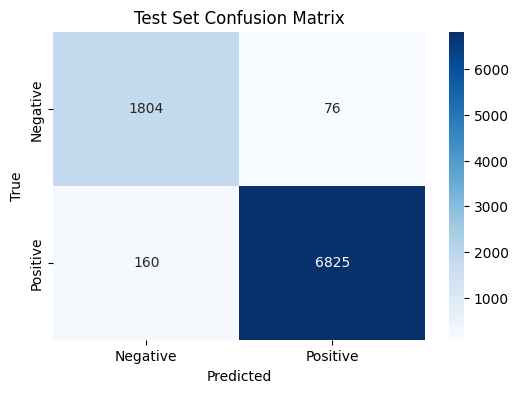

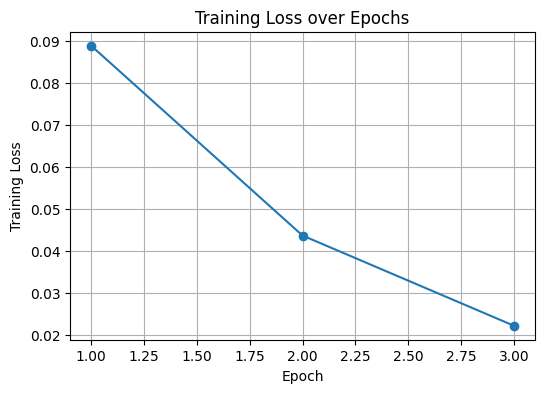

In [8]:
# Confusion matrix Visualization
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test Set Confusion Matrix")
plt.show()

# Loss curve Visualization
plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), loss_values, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.show()

In [9]:
learning_rate = 3e-5

optimizer = AdamW(model.parameters(), lr=learning_rate)

loss_values = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())
    
    avg_loss = total_loss / len(train_loader)
    loss_values.append(avg_loss)
    print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")

# Validation Evaluation for new learning rate
val_labels, val_preds = evaluate(model, val_loader)
print("\nValidation Classification Report:")
print(classification_report(val_labels, val_preds, target_names=["Negative", "Positive"]))

# Test Evaluation for new learning rate
test_labels, test_preds = evaluate(model, test_loader)
print("\nTest Classification Report:")
print(classification_report(test_labels, test_preds, target_names=["Negative", "Positive"]))

c:\Users\krush\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/3: 100%|██████████| 4432/4432 [32:25<00:00,  2.28it/s, loss=0.00252] 


Epoch 1 Loss: 0.0235


Epoch 2/3: 100%|██████████| 4432/4432 [32:25<00:00,  2.28it/s, loss=0.00175] 


Epoch 2 Loss: 0.0195


Epoch 3/3: 100%|██████████| 4432/4432 [32:26<00:00,  2.28it/s, loss=0.00046] 


Epoch 3 Loss: 0.0168

Validation Classification Report:
              precision    recall  f1-score   support

    Negative       0.93      0.94      0.94      1845
    Positive       0.99      0.98      0.98      7018

    accuracy                           0.97      8863
   macro avg       0.96      0.96      0.96      8863
weighted avg       0.97      0.97      0.97      8863


Test Classification Report:
              precision    recall  f1-score   support

    Negative       0.94      0.95      0.94      1880
    Positive       0.99      0.98      0.98      6985

    accuracy                           0.98      8865
   macro avg       0.96      0.96      0.96      8865
weighted avg       0.98      0.98      0.98      8865

